In [9]:
import os
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# --- Configure once ---
TARGET_COL = "is_ai"

# Order your preferred candidates here (edit as needed)
CANDIDATES = [
    "./raid_sample_small_with_features_CLEANED.csv",
]

def _choose_path(cands):
    for p in cands:
        if p and os.path.exists(p):
            return p
    raise FileNotFoundError("None of the candidate dataset paths exist. Edit CANDIDATES.")

def _read_any(path: str) -> pd.DataFrame:
    ext = os.path.splitext(path)[1].lower()
    if ext in (".parquet", ".pq"):
        return pd.read_parquet(path)
    return pd.read_csv(path, low_memory=False)

# Load DF
DATA_PATH = _choose_path(CANDIDATES)
print(f"[INFO] Loading: {DATA_PATH}")
df_with_features = _read_any(DATA_PATH)

# Target: keep it minimal; coerce to {0,1}
def make_target(df: pd.DataFrame) -> pd.Series:
    y = df[TARGET_COL]
    if y.dtype == bool:
        return y.astype(int)
    if np.issubdtype(y.dtype, np.number):
        return y.fillna(0).astype(int).clip(0,1)
    # string-ish: try a simple mapping
    y2 = y.astype(str).str.lower().map({"ai":1,"1":1,"true":1,"yes":1,"human":0,"0":0,"false":0,"no":0})
    return y2.fillna(0).astype(int)

# y vector for the analyses
y = make_target(df_with_features)
print(f"[INFO] Rows: {len(df_with_features):,} | is_ai distribution: {y.value_counts().sort_index().to_dict()}")


[INFO] Loading: ./raid_sample_small_with_features_CLEANED.csv
[INFO] Rows: 3,000 | is_ai distribution: {0: 1500, 1: 1500}


In [10]:
def mann_whitney_auc(x: np.ndarray, y: np.ndarray) -> float:
    try:
        pos = x[y == 1]; neg = x[y == 0]
        if len(pos) == 0 or len(neg) == 0: return np.nan
        U, _ = stats.mannwhitneyu(pos, neg, alternative="two-sided")
        auc = U / (len(pos) * len(neg))
        return max(auc, 1 - auc)  # ensure >= 0.5
    except Exception:
        return np.nan

def cohens_d(x: np.ndarray, y: np.ndarray) -> float:
    a = x[y == 1]; b = x[y == 0]
    if len(a) < 2 or len(b) < 2: return np.nan
    m1, m0 = np.nanmean(a), np.nanmean(b)
    s1, s0 = np.nanstd(a, ddof=1), np.nanstd(b, ddof=1)
    n1, n0 = len(a), len(b)
    sp = np.sqrt(((n1-1)*s1**2 + (n0-1)*s0**2) / (n1 + n0 - 2)) if (n1+n0-2) > 0 else np.nan
    return np.abs((m1 - m0) / sp) if sp > 0 else np.nan

def cliffs_delta(x: np.ndarray, y: np.ndarray) -> float:
    auc = mann_whitney_auc(x, y)
    if np.isnan(auc): return np.nan
    return np.abs(2*auc - 1)

def residualize_against_length(df: pd.DataFrame, features: list, length_col: str = LENGTH_COL) -> pd.DataFrame:
    out = df[features].copy()
    if length_col not in df.columns: return out
    x = np.log1p(df[length_col].astype(float))
    X = np.vstack([np.ones(len(x)), x.fillna(x.median())]).T
    for f in features:
        s = df[f].astype(float)
        mask = s.notna() & np.isfinite(s)
        if mask.sum() < 5:
            out[f] = s
            continue
        y = s[mask].values
        Xm = X[mask.values]
        try:
            beta = np.linalg.lstsq(Xm, y, rcond=None)[0]
            yhat = X @ beta
            out[f] = s - yhat
        except Exception:
            out[f] = s
    return out


In [11]:
def univariate_report(df: pd.DataFrame, length_control: bool = False, top_k: int = 30) -> pd.DataFrame:
    y = make_target(df).values
    feats = select_numeric_features(df)
    M = df[feats].copy()
    if length_control:
        M = residualize_against_length(df, feats, LENGTH_COL)

    rows = []
    for f in feats:
        x = M[f].values.astype(float)
        finite = np.isfinite(x) & ~np.isnan(x)
        if finite.sum() < 20: 
            continue
        xv = x[finite]; yv = y[finite]
        if yv.min() == yv.max(): 
            continue
        auc = mann_whitney_auc(xv, yv)
        mi  = mutual_info_classif(xv.reshape(-1,1), yv, random_state=7)[0]
        d   = cohens_d(xv, yv)
        cd  = cliffs_delta(xv, yv)
        rows.append(dict(feature=f, auc=auc, mi=mi, cohens_d=d, cliffs_delta=cd,
                         n=len(xv), mean_ai=np.nanmean(xv[yv==1]) if (yv==1).any() else np.nan,
                         mean_h=np.nanmean(xv[yv==0]) if (yv==0).any() else np.nan))
    if not rows: 
        return pd.DataFrame(columns=["feature","auc","mi","cohens_d","cliffs_delta","n","mean_ai","mean_h"])
    out = pd.DataFrame(rows)
    out["rank_score"] = out["auc"].fillna(0) + 1e-3*out["mi"].fillna(0) + 1e-4*out["cohens_d"].abs().fillna(0)
    return out.sort_values(["rank_score","auc","mi","cohens_d"], ascending=[False,False,False,False]).head(top_k)


In [12]:
uni_raw = univariate_report(df_with_features, length_control=False, top_k=40)
uni_lenctrl = univariate_report(df_with_features, length_control=True, top_k=40)

print("Top univariate (raw):")
display(uni_raw)

print("\nTop univariate (length-controlled by residuals over log tokens):")
display(uni_lenctrl)


Top univariate (raw):


,feature,auc,mi,cohens_d,cliffs_delta,n,mean_ai,mean_h,rank_score
41,mtld,0.635293,0.250577,0.225885,0.270587,3000,137.276373,87.039769,0.635566
14,sentence_length_std,0.609198,0.051721,0.050560,0.218395,3000,9.564869,9.957468,0.609254
22,trigram_diversity,0.592223,0.072739,0.410734,0.184447,3000,0.927118,0.978764,0.592337
40,yules_k,0.583129,0.126068,0.275970,0.166258,3000,164.964005,126.491973,0.583283
5,avg_word_length,0.582083,0.025904,0.273364,0.164167,3000,4.837889,4.673344,0.582137
21,bigram_diversity,0.569682,0.100447,0.403308,0.139365,3000,0.868298,0.920714,0.569823
30,unique_char_count,0.568108,0.010263,0.217408,0.136216,3000,45.604000,47.887333,0.568140
27,char_trigram_entropy,0.563588,0.026659,0.316825,0.127175,3000,8.773076,8.974037,0.563646
36,left_dependency_ratio,0.559320,0.013471,0.160565,0.118640,3000,0.472482,0.482773,0.559350
37,right_dependency_ratio,0.559320,0.012217,0.160565,0.118640,3000,0.527518,0.517227,0.559348



Top univariate (length-controlled by residuals over log tokens):


,feature,auc,mi,cohens_d,cliffs_delta,n,mean_ai,mean_h,rank_score
22,trigram_diversity,0.636507,0.056836,0.437532,0.273013,3000,-0.027227,0.027227,0.636607
21,bigram_diversity,0.605962,0.063660,0.443235,0.211925,3000,-0.028255,0.028255,0.606070
14,sentence_length_std,0.594249,0.053981,0.023778,0.188498,3000,-0.091281,0.091281,0.594305
32,bits_per_char,0.591635,0.016504,0.390100,0.183269,3000,-0.117173,0.117173,0.591690
31,compression_ratio,0.589846,0.041785,0.398135,0.179692,3000,-0.014344,0.014344,0.589928
40,yules_k,0.589490,0.104684,0.286753,0.178980,3000,19.941322,-19.941322,0.589623
26,char_trigram_diversity,0.574859,0.043363,0.341891,0.149717,3000,-0.013829,0.013829,0.574936
5,avg_word_length,0.572195,0.000000,0.254442,0.144391,3000,0.076190,-0.076190,0.572221
20,unigram_diversity,0.567793,0.078708,0.108976,0.135586,3000,-0.006856,0.006856,0.567883
36,left_dependency_ratio,0.560792,0.002039,0.164292,0.121585,3000,-0.005263,0.005263,0.560811


In [14]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

def multivariate_signals(df: pd.DataFrame, max_features: int = 60, do_cv: bool = False, cv_folds: int = 5) -> dict:
    # --- target ---
    y = make_target(df).astype(int).values  # ensure no NaNs in y

    # --- features: numeric only, coerce, clean ---
    feats = select_numeric_features(df)
    X = df[feats].apply(pd.to_numeric, errors="coerce")
    X = X.replace([np.inf, -np.inf], np.nan)

    # drop columns that are entirely NaN
    all_nan_cols = X.columns[X.isna().all()]
    if len(all_nan_cols) > 0:
        X = X.drop(columns=all_nan_cols)

    # drop zero-variance columns (after coercion)
    const_cols = X.columns[X.nunique(dropna=False) <= 1]
    if len(const_cols) > 0:
        X = X.drop(columns=const_cols)

    feats = X.columns.tolist()  # refresh after drops

    # ==== (A) L1-Logistic with impute+scale ====
    # separate imputer so we can extract indicator names
    imp_lr = SimpleImputer(strategy="median", add_indicator=True)
    X_imp_lr = imp_lr.fit_transform(X)

    # build feature names incl. missing indicators
    if hasattr(imp_lr, "indicator_") and imp_lr.indicator_ is not None:
        miss_idx = imp_lr.indicator_.features_.tolist()
        indicator_names = [f"{feats[i]}__missing" for i in miss_idx]
    else:
        indicator_names = []
    feats_lr = feats + indicator_names

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X_imp_lr)

    lr = LogisticRegression(penalty="l1", solver="liblinear", max_iter=2000, random_state=7)
    if do_cv:
        from sklearn.model_selection import cross_val_score
        auc_lr = cross_val_score(lr, Xs, y, cv=cv_folds, scoring="roc_auc").mean()

    lr.fit(Xs, y)
    coef_abs = np.abs(lr.coef_[0])
    imp_lr_series = pd.Series(coef_abs, index=feats_lr).sort_values(ascending=False).head(max_features)
    top_lr = imp_lr_series.reset_index().rename(columns={"index": "feature", 0: "abs_coef"})

    # ==== (B) Random Forest + permutation importance (no scaling) ====
    # For RF we usually don't need missing indicators; use a plain imputer
    imp_rf = SimpleImputer(strategy="median", add_indicator=False)
    X_imp_rf = imp_rf.fit_transform(X)

    rf = RandomForestClassifier(
        n_estimators=500, max_depth=None, min_samples_leaf=2,
        random_state=7, n_jobs=-1
    )
    if do_cv:
        from sklearn.model_selection import cross_val_score
        auc_rf = cross_val_score(rf, X_imp_rf, y, cv=cv_folds, scoring="roc_auc").mean()

    rf.fit(X_imp_rf, y)
    perm = permutation_importance(rf, X_imp_rf, y, n_repeats=10, random_state=7, n_jobs=-1)
    imp_perm_series = pd.Series(perm.importances_mean, index=feats).sort_values(ascending=False).head(max_features)
    top_rf = imp_perm_series.reset_index().rename(columns={"index": "feature", 0: "perm_importance"})

    out = {
        "logreg_L1_top": top_lr,
        "rf_perm_top":   top_rf,
        "dropped_all_nan": list(all_nan_cols),
        "dropped_constant": list(const_cols),
    }
    if do_cv:
        out["auc_lr_cv"] = auc_lr
        out["auc_rf_cv"] = auc_rf
    return out


In [15]:
multi = multivariate_signals(df_with_features, max_features=40, do_cv=False)

print("Top features by L1-logistic absolute coefficient:")
display(multi["logreg_L1_top"])

print("\nTop features by RandomForest permutation importance:")
display(multi["rf_perm_top"])

print("\nDropped (all-NaN) columns:", multi["dropped_all_nan"])
print("Dropped (constant) columns:", multi["dropped_constant"])


Top features by L1-logistic absolute coefficient:


,feature,abs_coef
0,bigram_diversity,2.987842
1,n_tok,2.353618
2,unigram_diversity,1.952291
3,trigram_entropy,1.636080
4,n_chars,1.234864
5,avg_word_length,1.142014
6,mtld,1.033448
7,whitespace_ratio,0.981839
8,entropy_bits,0.796477
9,std_word_length,0.729393



Top features by RandomForest permutation importance:


,feature,perm_importance
0,mtld,0.193033
1,sentence_length_std,0.008733
2,yules_k,0.004867
3,n_tokens_ws,0.001567
4,trigram_diversity,0.001567
5,colon_ratio,0.000833
6,right_dependency_ratio,0.000833
7,comma_ratio,0.000633
8,flesch_reading_ease,0.000533
9,avg_word_length,0.000467



Dropped (all-NaN) columns: ['not_text_reason']
Dropped (constant) columns: []


In [16]:
def redundancy_overview(df: pd.DataFrame, top_features: list | None = None, k: int = 30) -> pd.DataFrame:
    feats = top_features if top_features is not None else select_numeric_features(df)
    feats = [f for f in feats if f in df.columns]
    X = df[feats].astype(float).replace([np.inf,-np.inf], np.nan).fillna(df[feats].median(numeric_only=True))
    corr = X.corr(method="spearman").abs()
    # For readability, show the k most inter-correlated pairs (excluding diagonal)
    tri = corr.where(~np.eye(len(corr), dtype=bool))
    pairs = tri.unstack().dropna().sort_values(ascending=False)
    pairs = pairs.reset_index()
    pairs.columns = ["feature_1","feature_2","|spearman|"]
    return pairs.head(k)

# Example: inspect redundancy among the union of top-20 from several rankings
top_union = pd.unique(
    pd.concat([
        uni_raw["feature"].head(20),
        uni_lenctrl["feature"].head(20),
        multi["logreg_L1_top"]["feature"].head(20),
        multi["rf_perm_top"]["feature"].head(20)
    ], ignore_index=True)
).tolist()

redundant_pairs = redundancy_overview(df_with_features, top_features=top_union, k=40)
print("Most redundant pairs among candidate features:")
display(redundant_pairs)


Most redundant pairs among candidate features:


,feature_1,feature_2,|spearman|
0,left_dependency_ratio,right_dependency_ratio,1.000000
1,right_dependency_ratio,left_dependency_ratio,1.000000
2,bits_per_char,compression_ratio,0.999999
3,compression_ratio,bits_per_char,0.999999
4,n_tok,n_tokens_ws,0.993630
5,n_tokens_ws,n_tok,0.993630
6,trigram_entropy,bigram_entropy,0.987249
7,bigram_entropy,trigram_entropy,0.987249
8,n_tokens_ws,n_chars,0.975047
9,n_chars,n_tokens_ws,0.975047


In [18]:
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# Assumptions:
# - Your dataframe is df_with_features
# - Binary target accessor:
def y_target(df): 
    # 1 = AI, 0 = human — adapt to your schema if needed
    if "is_ai" in df.columns: 
        return df["is_ai"].astype(int).values
    if "source_type" in df.columns:
        return (df["source_type"].astype(str).str.lower() != "human").astype(int).values
    if "model" in df.columns:
        return (df["model"].astype(str).str.lower() != "human").astype(int).values
    raise ValueError("Provide a target column.")

# Utility: safe AUC that tolerates degenerate splits
def safe_auc(y, s):
    y = np.asarray(y); s = np.asarray(s)
    if len(np.unique(y)) < 2: 
        return np.nan
    return roc_auc_score(y, s)


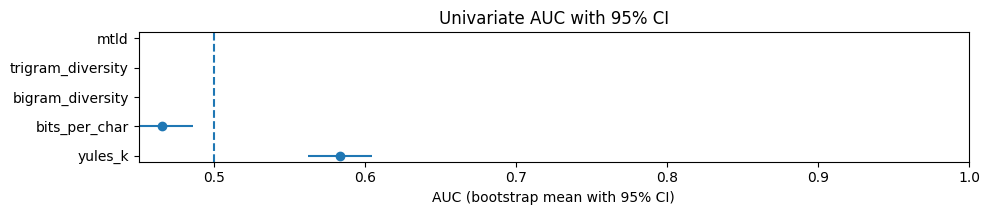

In [19]:
def bootstrap_auc_ci(x, y, B=1000, seed=7):
    rng = np.random.default_rng(seed)
    aucs = []
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    n = len(y)
    if n == 0 or len(np.unique(y)) < 2:
        return np.nan, (np.nan, np.nan)
    for _ in range(B):
        idx = rng.integers(0, n, n)
        aucs.append(safe_auc(y[idx], x[idx]))
    aucs = np.asarray(aucs)
    return float(np.nanmean(aucs)), (float(np.nanpercentile(aucs, 2.5)), float(np.nanpercentile(aucs, 97.5)))

def plot_univariate_auc_bootstrap(df, feature_list, B=1000, title="Univariate AUC with 95% CI"):
    y = y_target(df)
    rows = []
    for f in feature_list:
        x = pd.to_numeric(df[f], errors="coerce").values
        mean_auc, (lo, hi) = bootstrap_auc_ci(x, y, B=B)
        rows.append((f, mean_auc, lo, hi))
    res = pd.DataFrame(rows, columns=["feature","auc","lo","hi"]).dropna().sort_values("auc", ascending=False)

    plt.figure(figsize=(10, 0.45*len(res)))
    y_pos = np.arange(len(res))
    plt.errorbar(res["auc"], y_pos, xerr=[res["auc"]-res["lo"], res["hi"]-res["auc"]], fmt='o')
    plt.yticks(y_pos, res["feature"])
    plt.xlabel("AUC (bootstrap mean with 95% CI)")
    plt.title(title)
    plt.axvline(0.5, linestyle="--")
    plt.xlim(0.45, 1.0)
    plt.tight_layout()
    plt.show()

# Example:
plot_univariate_auc_bootstrap(df_with_features, ["trigram_diversity","bigram_diversity","bits_per_char","yules_k","mtld"], B=500)


C:\Users\marco\AppData\Local\Temp\ipykernel_21392\1397968623.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, g in pd.DataFrame({"x":x, "y":y, "q":q}).groupby("q"):
C:\Users\marco\AppData\Local\Temp\ipykernel_21392\1397968623.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, g in pd.DataFrame({"x":x, "y":y, "q":q}).groupby("q"):
C:\Users\marco\AppData\Local\Temp\ipykernel_21392\1397968623.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the f

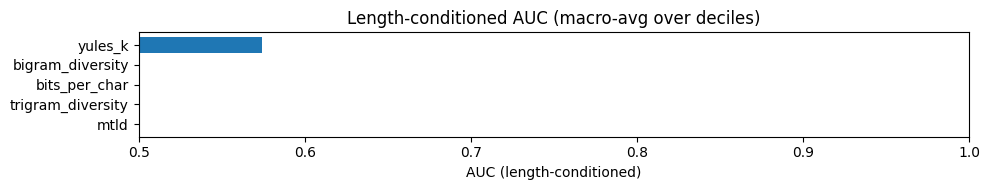

In [20]:
def length_conditioned_auc(df, feat, len_col="n_tokens_doc", bins=10):
    y = y_target(df)
    x = pd.to_numeric(df[feat], errors="coerce")
    L = pd.to_numeric(df[len_col], errors="coerce")
    mask = x.notna() & L.notna()
    x, L, y = x[mask], L[mask], y[mask]
    try:
        q = pd.qcut(L, bins, duplicates="drop")
    except Exception:
        return np.nan
    aucs = []
    for _, g in pd.DataFrame({"x":x, "y":y, "q":q}).groupby("q"):
        if g["y"].nunique() == 2:
            aucs.append(safe_auc(g["y"].values, g["x"].values))
    return float(np.nanmean(aucs)) if len(aucs) else np.nan

def plot_length_conditioned(df, feature_list, len_col="n_tokens_doc", title="Length-conditioned AUC (macro-avg over deciles)"):
    rows = []
    for f in feature_list:
        rows.append((f, length_conditioned_auc(df, f, len_col=len_col)))
    res = pd.DataFrame(rows, columns=["feature","auc_len_cond"]).dropna().sort_values("auc_len_cond", ascending=False)

    plt.figure(figsize=(10, 0.4*len(res)))
    plt.barh(res["feature"][::-1], res["auc_len_cond"][::-1])
    plt.xlabel("AUC (length-conditioned)")
    plt.title(title)
    plt.xlim(0.5, 1.0)
    plt.tight_layout()
    plt.show()

# Example:
plot_length_conditioned(df_with_features, ["trigram_diversity","bigram_diversity","bits_per_char","yules_k","mtld"])


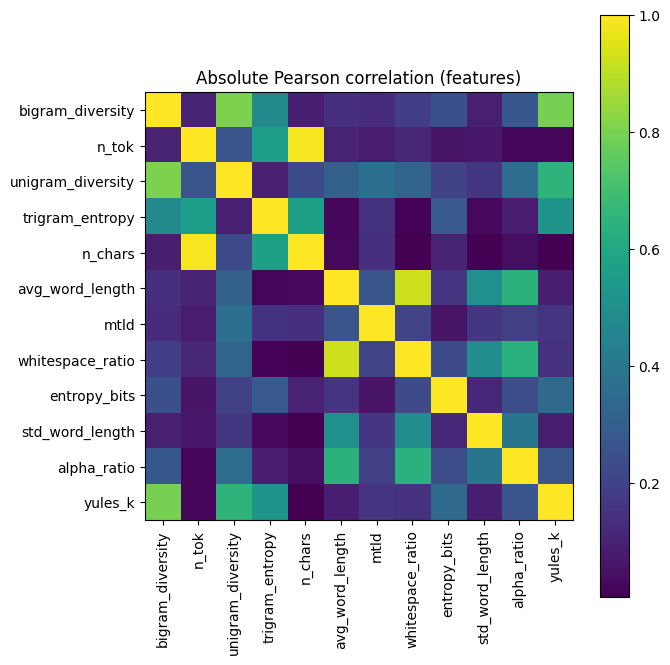

In [21]:
def plot_feature_correlation(df, feature_list, title="Absolute Pearson correlation (features)"):
    X = df[feature_list].apply(pd.to_numeric, errors="coerce")
    C = X.corr().abs()
    plt.figure(figsize=(1.0 + 0.5*len(feature_list), 1.0 + 0.5*len(feature_list)))
    plt.imshow(C.values, interpolation="nearest")
    plt.xticks(range(len(feature_list)), feature_list, rotation=90)
    plt.yticks(range(len(feature_list)), feature_list)
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example (use your L1 top 12):
l1_top12 = ["bigram_diversity","n_tok","unigram_diversity","trigram_entropy",
            "n_chars","avg_word_length","mtld","whitespace_ratio",
            "entropy_bits","std_word_length","alpha_ratio","yules_k"]
plot_feature_correlation(df_with_features, l1_top12)


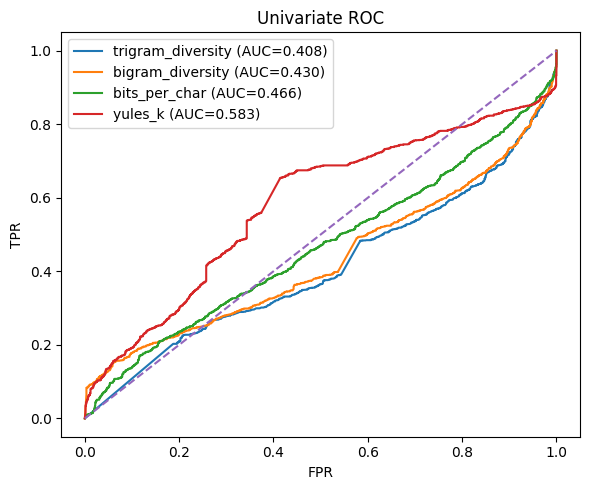

In [22]:
def plot_feature_roc(df, features, title="Univariate ROC"):
    y = y_target(df)
    plt.figure(figsize=(6,5))
    for f in features:
        x = pd.to_numeric(df[f], errors="coerce")
        mask = x.notna()
        if mask.sum() == 0 or len(np.unique(y[mask])) < 2:
            continue
        fpr, tpr, _ = roc_curve(y[mask], x[mask])
        auc = roc_auc_score(y[mask], x[mask])
        plt.plot(fpr, tpr, label=f"{f} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example:
plot_feature_roc(df_with_features, ["trigram_diversity","bigram_diversity","bits_per_char","yules_k"])
